In [1]:
from   astropy.table         import Table
import pylab                 as pl
import numpy                 as np
import pandas                as pd
import os
from   astropy.io            import fits
from   glob                  import glob
from   desitarget.targetmask import desi_mask, bgs_mask, mws_mask
from   scipy.spatial         import KDTree
import desispec.io
from matplotlib.ticker import FormatStrFormatter

In [2]:
from io import BytesIO 
from io import StringIO
import requests
import numpy as np 
from PIL import Image
def load_image(url): 
    res = requests.get(url)
    img_arr = np.array(Image.open(BytesIO(res.content)))
    return img_arr

In [3]:
params = {'legend.fontsize': '20',
          'figure.figsize': (7, 7),
         'axes.labelsize': '20',
         'axes.titlesize':'20',
         'figure.titlesize':'20',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'axes.labelpad' : '20'}
pl.rcParams.update(params)

In [4]:
data = Table.read('../../data/gama_gold_ddp.fits')

In [5]:
# data.keys()

In [6]:
#- Read the GAMA Data
ra_gama   = data['RA']
dec_gama  = data['DEC']
z_gama    = data['ZGAMA']
gmag_gama    = data['GMAG_DRED_SDSS']

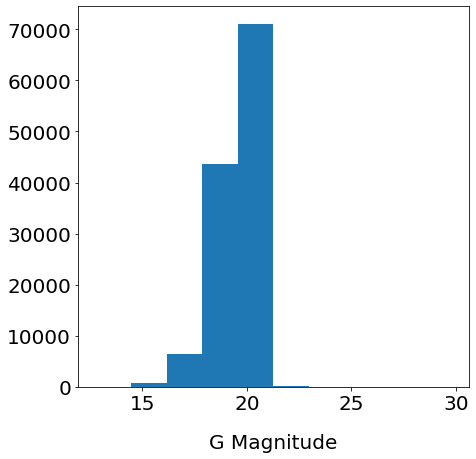

In [7]:
#- G Magnitude rom GAMA
_ = pl.hist(gmag_gama)
pl.xlabel('G Magnitude')
pl.show()

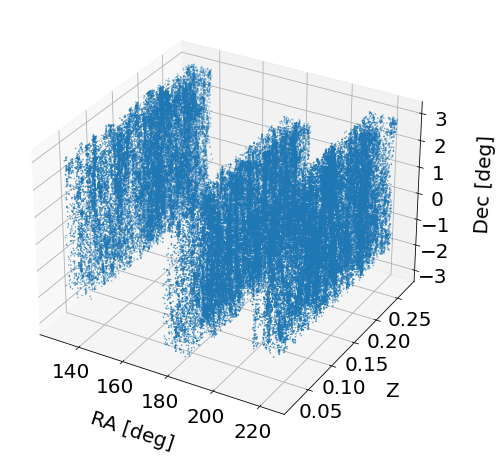

In [8]:
#- Plot RA Dec Z
fig = pl.figure(figsize=(8,8))
ax = pl.axes(projection='3d')
ax.scatter(ra_gama, z_gama, dec_gama, s=0.3)
ax.set_xlabel('RA [deg]')
ax.set_zlabel('Dec [deg]')
ax.set_ylabel('Z ')
pl.show()

In [9]:
#- Load the DES bright (BGS galaxies)
flavour = 'bright'
if flavour == 'bright':
    df_des = pd.read_csv('./data/DR9_BGSBRIGHT_data.csv')
else:
    df_des = pd.read_csv('./data/DR9_LRG_data.csv')

In [10]:
#- Load the Zcatalog from Everest sv3 to get Z DESI
specprod_eve = 'everest'
specprod_dir_eve = desispec.io.specprod_root(specprod_eve)
zpix_cat_eve = Table.read(f'{specprod_dir_eve}/zcatalog/zpix-sv3-{flavour}.fits', hdu="ZCATALOG")

# Selecting a random object which has multiple spectra in DESI
df_zcat_eve = zpix_cat_eve[['TARGETID','Z']].to_pandas()
# df_zcat_eve

In [11]:
#- Load the Zcatalog from Fuji sv3 to get Z DESI
specprod_fuji = 'fuji'    
specprod_dir_fuji = desispec.io.specprod_root(specprod_fuji)
zpix_cat_fuji = Table.read(f'{specprod_dir_fuji}/zcatalog/zpix-sv3-{flavour}.fits', hdu="ZCATALOG")

# Selecting a random object which has multiple spectra in DESI
df_zcat_fuji = zpix_cat_fuji[['TARGETID','Z']].to_pandas()
# df_zcat_fuji

In [12]:
#- Load the Zcatalog from Guadalupe main to get Z DESI
specprod_gua = 'guadalupe'  
specprod_dir_gua = desispec.io.specprod_root(specprod_gua)
zpix_cat_gua = Table.read(f'{specprod_dir_gua}/zcatalog/zpix-main-{flavour}.fits', hdu="ZCATALOG")
# Selecting a random object which has multiple spectra in DESI
df_zcat_gua = zpix_cat_gua[['TARGETID','Z']].to_pandas()
# df_zcat_gua

In [13]:
#- Match TARGETID from Everest+Fuji and Guadalupe
df_zcat = df_zcat_fuji.append(df_zcat_eve)
df_zcat = df_zcat.append(df_zcat_gua)
df_zcat = df_zcat[~df_zcat.duplicated()]
df_zcat = df_zcat[df_zcat['TARGETID']>0]
# df_zcat
# df_zcat = df_zcat_fuji

In [14]:
#- Match TARGETID from DES and DESI to get Z_DES
df_des = pd.merge(df_des, df_zcat)
df_des

,ID,RA,DEC,TARGETID,E1,E2,E,R,BA,PHI,GMAG,Z
0,83552.0,176.519157,69.153943,3.963348e+16,-0.186099,-0.236478,0.300924,3.341902,0.537369,-1.118768,20.029436,0.123489
1,83565.0,176.575056,69.971485,3.963349e+16,0.008509,-0.005386,0.010070,0.614454,0.980061,-0.282154,20.144777,0.154047
2,83578.0,176.886167,69.036958,3.963348e+16,0.017661,0.003797,0.018065,0.885914,0.964512,0.105887,20.084570,0.205825
3,83582.0,176.175303,69.592200,3.963349e+16,0.408696,0.369491,0.550960,1.334053,0.289524,0.367530,19.021137,0.118404
4,83647.0,177.820201,69.820738,3.963349e+16,0.324213,0.544455,0.633676,0.903371,0.224233,0.516853,20.118868,0.192698
...,...,...,...,...,...,...,...,...,...,...,...,...
15027,1606146.0,318.824012,-3.894122,3.962769e+16,0.236043,-0.205309,0.312839,1.271114,0.523416,-0.357938,19.407232,0.139321
15028,1606221.0,319.015147,-3.669305,3.962770e+16,-0.023328,-0.209223,0.210520,1.954110,0.652183,-0.840919,20.228525,0.247809
15029,1606288.0,313.279134,-3.051211,3.962772e+16,0.314769,0.165225,0.355498,0.584606,0.475473,0.241687,19.232449,0.057327
15030,1606305.0,312.969883,-3.971610,3.962769e+16,0.097620,0.039443,0.105287,0.787451,0.809484,0.191993,19.826538,0.119811


In [15]:
#- Load Final RA DEC Z GMAG from DES
ra_des  = df_des['RA']
dec_des = df_des['DEC']
gmag_des = df_des['GMAG']
z_des = df_des['Z']

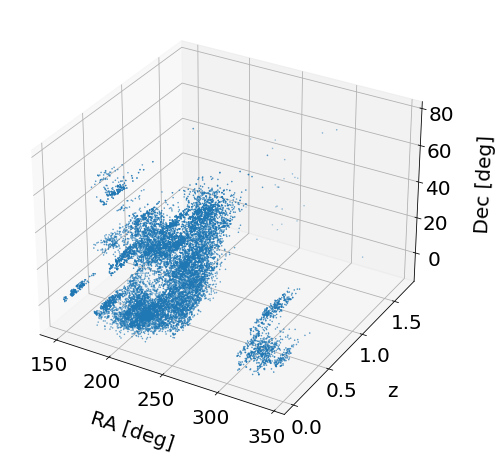

In [16]:
#- Plot RA Dec Z from DES
fig = pl.figure(figsize=(8,8))
ax = pl.axes(projection='3d')
ax.scatter(ra_des, z_des, dec_des, s=0.3)
ax.set_xlabel('RA [deg]')
ax.set_zlabel('Dec [deg]')
ax.set_ylabel('z ')
pl.show()

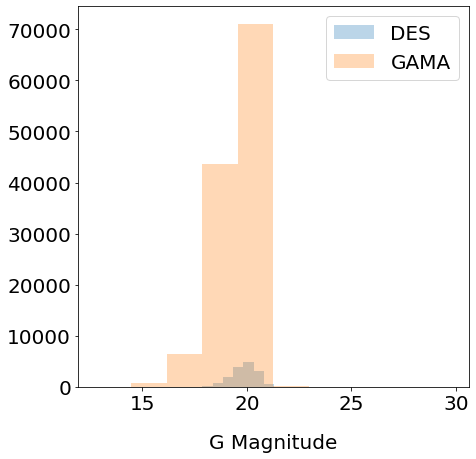

In [17]:
_ = pl.hist(gmag_des, label='DES', alpha=0.3)
_ = pl.hist(gmag_gama, label='GAMA', alpha=0.3)
pl.xlabel('G Magnitude')
pl.legend()

In [18]:
len(gmag_des), len(gmag_gama)

(15032, 121975)

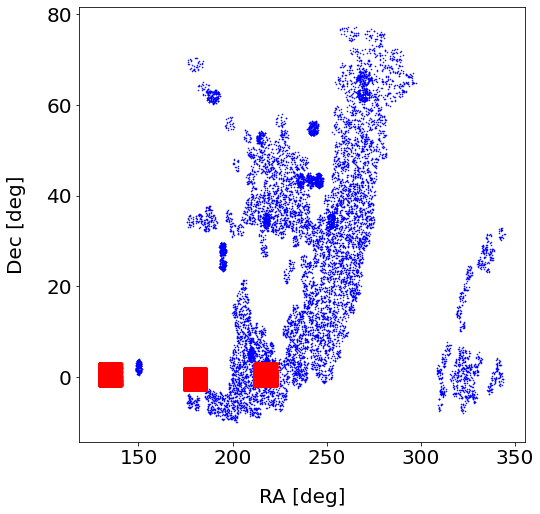

In [19]:
#- Plot the match RA Dec from GAMA region in the DES catalog
fig = pl.figure(figsize=(8,8))
pl.scatter(ra_des,  dec_des,  s=0.3, c='b')
pl.scatter(ra_gama, dec_gama, s=0.3, c='r')
pl.xlabel('RA [deg]')
pl.ylabel('Dec [deg]')
pl.show()

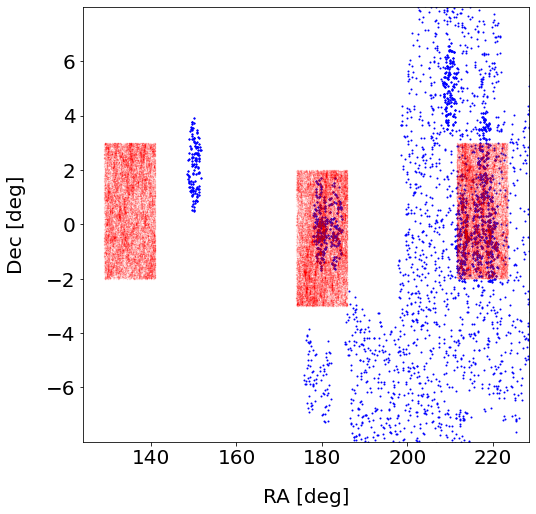

In [20]:
#- RA Dec Match zoom in
fig = pl.figure(figsize=(8,8))
pl.scatter(ra_des,  dec_des,  s=1, c='b')
pl.scatter(ra_gama, dec_gama, s=0.1, c='r', alpha=0.1)
pl.xlim(min(ra_gama)-5,max(ra_gama)+5)
pl.ylim(min(dec_gama)-5,max(dec_gama)+5)
pl.xlabel('RA [deg]')
pl.ylabel('Dec [deg]')
pl.show()

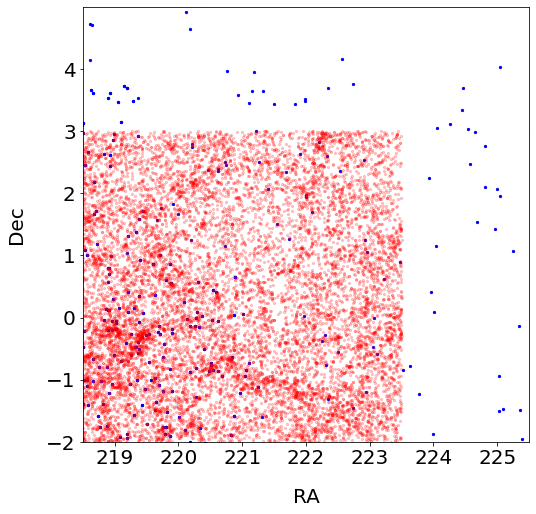

In [21]:
#- RA Dec Match zoom in more
fig = pl.figure(figsize=(8,8))
pl.scatter(np.around(ra_des,  3), np.around(dec_des,  3), s=5, c='b')
pl.scatter(np.around(ra_gama, 3), np.around(dec_gama, 3), s=5, c='r', alpha=0.2)
pl.xlim(max(ra_gama)-5, max(ra_gama)+2)
pl.ylim(max(dec_gama)-5, max(dec_gama)+2)
pl.xlabel('RA')
pl.ylabel('Dec')
pl.show()

In [22]:
#- Load trees for des data to find k=1 nearest using ra,dec,z
tree = KDTree(np.c_[ra_des, dec_des, z_des])

In [23]:
# Find the 1-NN for each GAMA RA Dec
distances, indices = tree.query(np.c_[ra_gama, dec_gama, z_gama], k=1)

In [24]:
len(indices), len(ra_gama)

(121975, 121975)

Text(0.5, 0, 'Distance [Mpc]')

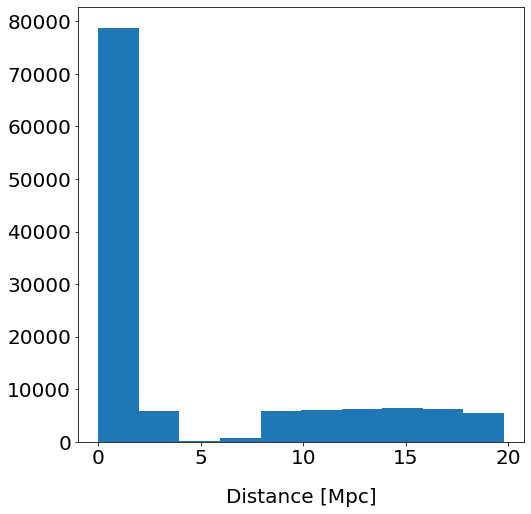

In [25]:
fig = pl.figure(figsize=(8,8))
_ = pl.hist(distances)
pl.xlabel('Distance [Mpc]')

In [26]:
np.shape(indices), indices[0]

((121975,), 12103)

In [27]:
# Ordening the DES entries using the IDs get for indices
df_des.iloc[indices]

,ID,RA,DEC,TARGETID,E1,E2,E,R,BA,PHI,GMAG,Z
12103,955633.0,148.475602,1.840702,3.962783e+16,0.156392,0.183377,0.241009,0.841738,0.611591,0.432326,19.740505,0.110441
11920,937223.0,177.915261,0.327289,3.962779e+16,-0.000816,0.134562,0.134564,0.760452,0.762791,0.788429,20.345068,-0.001996
9797,870772.0,215.695560,0.310354,3.962779e+16,0.129518,-0.035747,0.134360,2.049676,0.763109,-0.134647,20.379623,0.234815
9929,871306.0,217.155778,0.802825,3.962781e+16,-0.155031,-0.493127,0.516923,1.290352,0.318458,-0.937698,19.478088,0.127038
12103,955633.0,148.475602,1.840702,3.962783e+16,0.156392,0.183377,0.241009,0.841738,0.611591,0.432326,19.740505,0.110441
...,...,...,...,...,...,...,...,...,...,...,...,...
9388,868797.0,220.540384,0.440204,3.962780e+16,-0.004174,0.023976,0.024337,1.300240,0.952483,0.871580,19.660362,0.000066
9819,870877.0,216.314597,0.296055,3.962779e+16,0.159037,0.137995,0.210559,1.236018,0.652129,0.357337,20.156103,0.227439
12103,955633.0,148.475602,1.840702,3.962783e+16,0.156392,0.183377,0.241009,0.841738,0.611591,0.432326,19.740505,0.110441
10722,881368.0,212.341757,1.454711,3.962782e+16,0.204399,0.049574,0.210325,1.175615,0.652449,0.118970,19.576862,0.164439


In [28]:
# df_match = pd.DataFrame( df_des.iloc[indices], data )
# df_match

In [29]:
len(data), len(df_des.iloc[indices])

(121975, 121975)

In [30]:
data_match = data.copy()

In [31]:
df_des.keys()

Index(['ID', 'RA', 'DEC', 'TARGETID', 'E1', 'E2', 'E', 'R', 'BA', 'PHI',
       'GMAG', 'Z'],
      dtype='object')

In [32]:
# Match GAMA and DES
data_match['RA_DES']              = df_des['RA'].iloc[indices]
data_match['DEC_DES']             = df_des['DEC'].iloc[indices]
# data_match['Z_DES']               = df_des['Z'].iloc[indices]
data_match['TARGETID_DES']        = np.array(df_des['TARGETID'].iloc[indices], dtype=int)
data_match['E1_DES']              = df_des['E1'].iloc[indices]
data_match['E2_DES']              = df_des['E2'].iloc[indices]
data_match['E_DES']               = df_des['E'].iloc[indices]
data_match['R_DES']               = df_des['R'].iloc[indices]
data_match['BA_DES']              = df_des['BA'].iloc[indices]
data_match['PHI_DES']             = df_des['PHI'].iloc[indices]
data_match['GMAG_DES']            = df_des['GMAG'].iloc[indices]
data_match['DISTANCE_MATCH_DES']  = distances

In [33]:
data_match.keys()

['CATAID',
 'OBJID',
 'RA',
 'DEC',
 'R_PETRO',
 'ZGAMA',
 'NQ',
 'SPECID',
 'SURVEY_CLASS',
 'UMAG_DRED_SDSS',
 'GMAG_DRED_SDSS',
 'RMAG_DRED_SDSS',
 'IMAG_DRED_SDSS',
 'ZMAG_DRED_SDSS',
 'ZSURV',
 'LUMDIST',
 'DISTMOD',
 'FIELD',
 'IN_D8LUMFN',
 'CONSERVATIVE',
 'CARTESIAN_X',
 'CARTESIAN_Y',
 'CARTESIAN_Z',
 'ROTCARTESIAN_X',
 'ROTCARTESIAN_Y',
 'ROTCARTESIAN_Z',
 'GMR',
 'DETMAG',
 'REST_GMR_0P1',
 'REST_GMR_0P1_WARN',
 'REST_GMR_0P1_INDEX',
 'KCORR_R0P1',
 'KCORR_G0P1',
 'KCORR_R0P0',
 'KCORR_G0P0',
 'REST_GMR_0P0',
 'Q_COLOR_0P0',
 'EQ_ALL_0P0',
 'EQ_COLOR_0P0',
 'MALL_0P0',
 'MCOLOR_0P0',
 'MQZERO_0P0',
 'Z_THETA_QALL',
 'Z_THETA_QZERO',
 'Z_THETA_QCOLOR',
 'DDPKCORR_R0P1',
 'DDPKCORR_G0P1',
 'DDPKCORR_R0P0',
 'DDPKCORR_G0P0',
 'DDPMALL_0P0',
 'DELTA_DETMAG_FAINT',
 'ZMAX',
 'ZMAX_WARN',
 'DELTA_DETMAG_BRIGHT',
 'ZMIN',
 'ZMIN_WARN',
 'VMAX',
 'DDP',
 'DDPZLIMS',
 'STEPWISE_FAINTLIM_0P0',
 'STEPWISE_BRIGHTLIM_0P0',
 'RA_DES',
 'DEC_DES',
 'TARGETID_DES',
 'E1_DES',
 'E2_DES',
 '

In [34]:
data_match.write('./data/gamades_gold_ddp.fits', overwrite=True)

In [35]:
data_match.info

<Table length=121975>
         name           dtype  shape unit    class     n_bad
---------------------- ------- ----- ---- ------------ -----
                CATAID   int32            MaskedColumn     0
                 OBJID   int64            MaskedColumn     0
                    RA float64        deg       Column     0
                   DEC float64        deg       Column     0
               R_PETRO float32        mag       Column     0
                 ZGAMA float32                  Column     0
                    NQ   int16            MaskedColumn     0
                SPECID bytes33                  Column     0
          SURVEY_CLASS   int16            MaskedColumn     0
        UMAG_DRED_SDSS float32        mag       Column     0
        GMAG_DRED_SDSS float32        mag       Column     0
        RMAG_DRED_SDSS float32        mag       Column     0
        IMAG_DRED_SDSS float32        mag       Column     0
        ZMAG_DRED_SDSS float32        mag       Column     0
  

In [36]:
#- Filter for ddp1 GAMA
ii_ddp1 = data_match['DDP'][:,0] == 1
sum(ii_ddp1), len(ii_ddp1)

(50872, 121975)

In [37]:
#- Filter the match using a distance less than 0.001 
ii_distance = data_match['DISTANCE_MATCH_DES'] < 0.001
sum(ii_distance)

632

In [38]:
#- Final data lenght for ddp1 and minimal distance match with 1-NN
len(data_match['RA'][ii_ddp1 & ii_distance])

417

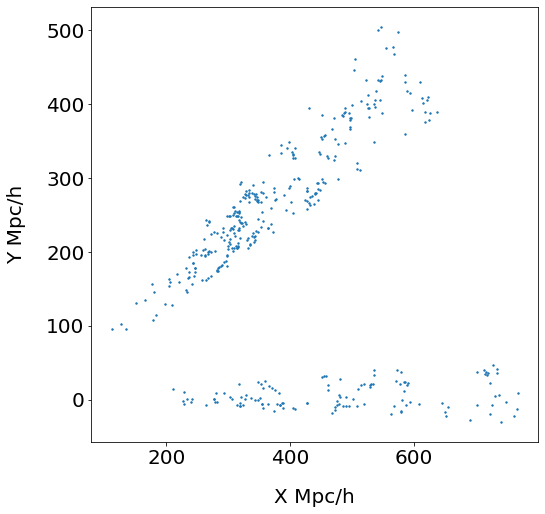

In [39]:
#- Final map for ddp1 and match_des filters
fig = pl.figure(figsize=(8,8))
pl.scatter( data_match['ROTCARTESIAN_X'][ii_ddp1 & ii_distance], data_match['ROTCARTESIAN_Y'][ii_ddp1 & ii_distance], s=2 )
pl.xlabel('X Mpc/h')
pl.ylabel('Y Mpc/h')
pl.show()

### G15

In [40]:
#- Field G15 GAMA
ii_g15 = data_match['FIELD'] == 'G15'
sum(ii_g15 & ii_ddp1)

16318

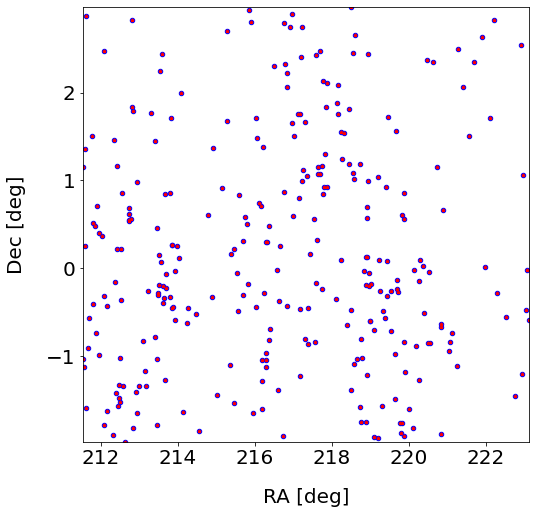

In [41]:
#- Apply the filters iiddp1 and ii_distance
fig = pl.figure(figsize=(8,8))
pl.scatter( data_match['RA'][ii_ddp1 & ii_distance], data_match['DEC'][ii_ddp1 & ii_distance], s=20, c='b', marker='o' )
pl.scatter( data_match['RA_DES'][ii_ddp1 & ii_distance], data_match['DEC_DES'][ii_ddp1 & ii_distance], s=10, c='r', marker='*' )
pl.xlim(min(ra_gama[ii_ddp1 & ii_distance & ii_g15]), max(ra_gama[ii_ddp1 & ii_distance & ii_g15]))
pl.ylim(min(dec_gama[ii_ddp1 & ii_distance & ii_g15]), max(dec_gama[ii_ddp1 & ii_distance & ii_g15]))
pl.xlabel('RA [deg]')
pl.ylabel('Dec [deg]')
pl.show()

In [42]:
#- Number of points in G15 for DDP1 matched with DES
len(data_match['RA'][ii_ddp1 & ii_distance & ii_g15])

293

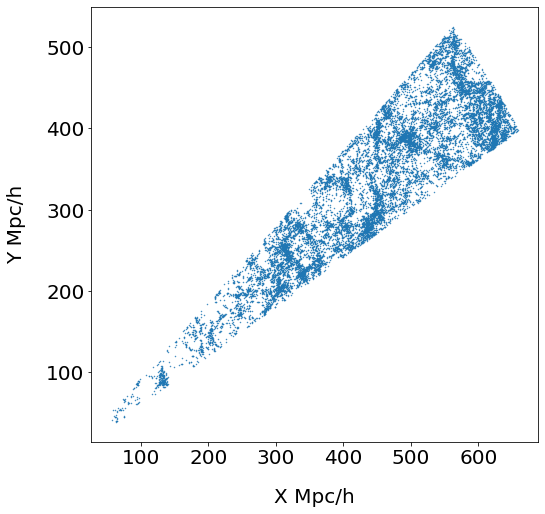

In [43]:
#- Final map for ddp1 and g15
fig = pl.figure(figsize=(8,8))
pl.scatter( data_match['ROTCARTESIAN_X'][ii_ddp1 & ii_g15], data_match['ROTCARTESIAN_Y'][ii_ddp1 & ii_g15], s=0.2 )
pl.xlabel('X Mpc/h')
pl.ylabel('Y Mpc/h')
pl.show()

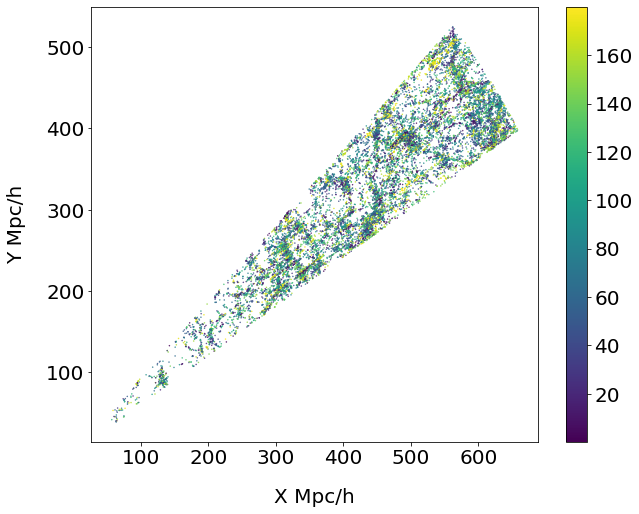

In [44]:
#- Final map for ddp1 and g15, color is the inclination 
fig = pl.figure(figsize=(10,8))
pl.scatter( data_match['ROTCARTESIAN_X'][ii_ddp1 & ii_g15], data_match['ROTCARTESIAN_Y'][ii_ddp1 & ii_g15], s=0.2, c=data_match['PHI_DES'][ii_ddp1 & ii_g15]*180/np.pi + 90)
pl.colorbar()
pl.xlabel('X Mpc/h')
pl.ylabel('Y Mpc/h')
pl.show()

In [45]:
#- DataFrame with final pos ddp1 g15
xyz_labels = ['ROTCARTESIAN_X','ROTCARTESIAN_Y','ROTCARTESIAN_Z']
df_pos = data[xyz_labels].to_pandas()
df_pos = df_pos[ii_ddp1 & ii_g15]
df_pos

,ROTCARTESIAN_X,ROTCARTESIAN_Y,ROTCARTESIAN_Z
10,376.361051,259.703020,-14.427125
24,609.593909,452.947333,-16.324600
30,378.189443,337.250361,24.247832
31,405.860384,283.908626,4.539176
53,467.229273,373.702543,-10.689510
...,...,...,...
121914,315.898864,247.876021,-13.606974
121929,276.450757,210.851126,0.188152
121933,358.783727,226.700636,8.862379
121954,636.725030,393.194120,-22.706112


In [46]:
#- Posicions git ddp1 + g15 to compute filaments
np.savetxt('./data/GAMADES_pos_ddp1_g15.txt', np.c_[np.arange(len(df_pos.values)), df_pos.values] , fmt='%d', header='id px py pz')

In [47]:
f = open('./data/GAMADES_pos_ddp1_g15.txt.NDnet_s2.up.NDskl.S010.a.NDskl')
doc = f.readlines()

In [48]:
# Number of filaments from Disperse
doc = np.array(doc)
ii = np.where(doc=='[FILAMENTS]\n')[0][0]
N_fila = int(doc[ii+1])
N_fila

1888

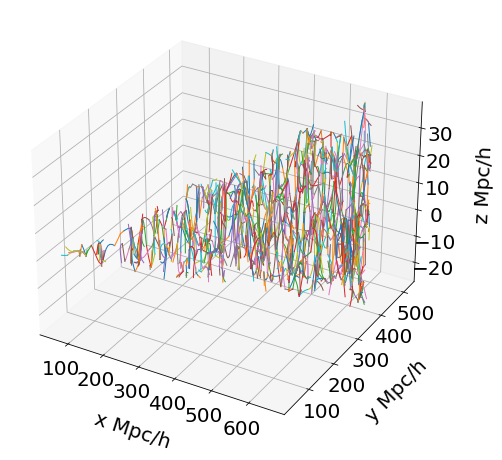

In [49]:
#- Plotting all the filaments
FILA = np.zeros(N_fila, dtype=object)
jj = ii+2
jj_new = 0
# print(doc[jj][0].replace('\n','').split(' ')[2])
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')
for i in range(N_fila):
    jj_new = jj + int(doc[jj].replace('\n','').split(' ')[2]) + 1
    FILA[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc[jj+1:jj_new]], dtype=float)
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    ax.plot3D(FILA[i][:,0], FILA[i][:,1], FILA[i][:,2], lw=1) 
    jj = jj_new

pl.savefig('./figs/GAMADES_nsig2_smooth_smooth10_ddp1_g15_3D.pdf', bbox_inches='tight')
pl.show()

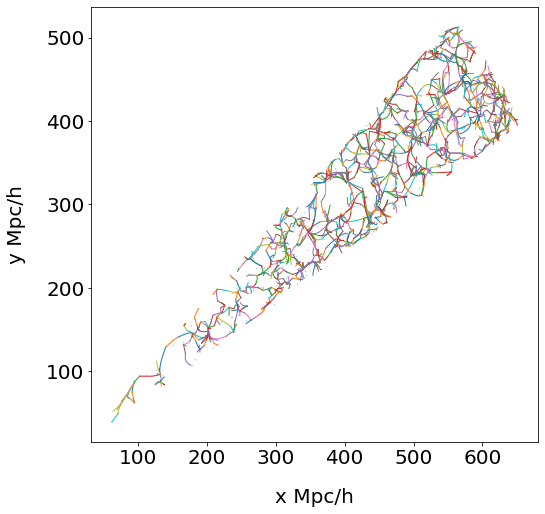

In [50]:
#- Plotting all the filaments in 2D
fig = pl.figure(figsize=(8,8), rasterized=True)
pl.scatter( data_match['ROTCARTESIAN_X'][ii_ddp1 & ii_distance & ii_g15], data_match['ROTCARTESIAN_Y'][ii_ddp1 & ii_distance & ii_g15], s=0.1, alpha=0.5 )
jj = ii+2
jj_new = 0
fila_x = []
fila_y = []
fila_z = []
for i in range(N_fila):
    jj_new = jj + int(doc[jj].replace('\n','').split(' ')[2]) + 1
    FILA[i] = np.array([a.replace('\n','').split(' ')[1:] for a in doc[jj+1:jj_new]], dtype=float)
    fila_x.append( FILA[i][:,0] ) 
    fila_y.append( FILA[i][:,1] ) 
    fila_z.append( FILA[i][:,2] ) 
    # print(jj,jj_new)
    # print(doc[jj].replace('\n',''),doc[jj_new])
    pl.plot(FILA[i][:,0], FILA[i][:,1], lw=1) 
    jj = jj_new
pl.xlabel('x Mpc/h')
pl.ylabel('y Mpc/h')
pl.savefig('./figs/GAMADES_nsig2_smooth_smooth10_ddp1_g15_2D.pdf', bbox_inches='tight')
pl.show()

In [51]:
sum(ii_ddp1 & ii_distance & ii_g15), sum(ii_ddp1 & ii_g15)

(293, 16318)

In [52]:
#Lenght of each filament
LEN_FILA = np.array([len(i) for i in FILA])
# LEN_FILA

## Finding the nearest Filament

In [53]:
def get_ID_FILA(pos,L):
    total = 0
    for i,l in enumerate(L):
        total += l
        if pos < total:
            return i

def get_distance(x1,y1,z1,x2,y2,z2):
    return np.sqrt( (x1-x2)**2 +(y1-y2)**2 +(z1-z2)**2   )

In [54]:
#- Extend all the filaments
fila_x_arr = np.concatenate(fila_x).ravel()
fila_y_arr = np.concatenate(fila_y).ravel()
fila_z_arr = np.concatenate(fila_z).ravel()
len(fila_x_arr)

13052

In [55]:
#- Setting the ID for the filaments
id_fila_arr = np.zeros(len(fila_x_arr))
for i in  np.arange(len(fila_x_arr)):
    id_fila_arr[i] = get_ID_FILA(i, LEN_FILA)

In [56]:
#- Save the filaments(segments) and their ids
df_fila = pd.DataFrame()
df_fila['id_fila'] = id_fila_arr
df_fila['x_fila'] = fila_x_arr
df_fila['y_fila'] = fila_y_arr
df_fila['z_fila'] = fila_z_arr
df_fila.to_csv('./data/filaments_ddp1_g15.csv')

In [57]:
#- DataFrame with positions matched with DESI
xyz_labels = ['ROTCARTESIAN_X','ROTCARTESIAN_Y','ROTCARTESIAN_Z']
df_pos_des = data[xyz_labels].to_pandas()
df_pos_des = df_pos_des[ii_ddp1 & ii_g15 & ii_distance]
# df_pos_des

In [58]:
#- Find the nearest filament point to each galaxy
tree_fila = KDTree(np.c_[fila_x_arr, fila_y_arr, fila_z_arr])
distances_fila, indices_fila = tree_fila.query(np.c_[df_pos_des], k=1)

In [59]:
#- Identifying the nearest segment using distance and Filament ID
ID_FILA = np.zeros(len(indices_fila), dtype=int)
ID_FILA_NEXT = np.zeros(len(indices_fila), dtype=int)
ID_FILA_LAST = np.zeros(len(indices_fila), dtype=int)
ID_FILA_SEGMENTS = np.zeros(len(indices_fila), dtype=object)
for i, index in enumerate(indices_fila):
    ID_FILA[i] = get_ID_FILA(index, LEN_FILA)
    ID_FILA_NEXT[i] = get_ID_FILA(index+1, LEN_FILA)
    ID_FILA_LAST[i] = get_ID_FILA(index-1, LEN_FILA)
    
    if (get_ID_FILA(index, LEN_FILA) == get_ID_FILA(index+1, LEN_FILA)) & (get_ID_FILA(index, LEN_FILA) != get_ID_FILA(index-1, LEN_FILA)):
        ID_FILA_SEGMENTS[i] = np.array([index,index+1])
    elif (get_ID_FILA(index, LEN_FILA) != get_ID_FILA(index+1, LEN_FILA)) & (get_ID_FILA(index, LEN_FILA) == get_ID_FILA(index-1, LEN_FILA)):
        ID_FILA_SEGMENTS[i] = np.array([index,index-1])
    elif (get_ID_FILA(index, LEN_FILA) == get_ID_FILA(index+1, LEN_FILA)) & (get_ID_FILA(index, LEN_FILA) == get_ID_FILA(index-1, LEN_FILA)):
        d_next = get_distance(fila_x_arr[index],fila_y_arr[index],fila_z_arr[index],fila_x_arr[index+1],fila_y_arr[index+1],fila_z_arr[index+1])
        d_last = get_distance(fila_x_arr[index],fila_y_arr[index],fila_z_arr[index],fila_x_arr[index-1],fila_y_arr[index-1],fila_z_arr[index-1])
        if d_next < d_last:
            ID_FILA_SEGMENTS[i] = np.array([index,index+1])
        elif d_next >= d_last:
            ID_FILA_SEGMENTS[i] = np.array([index,index-1])

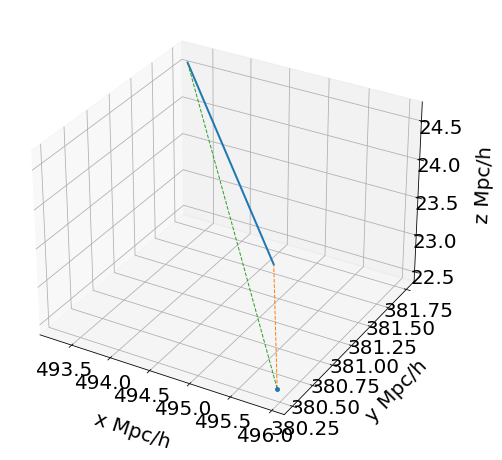

In [60]:
#- Plot the galaxy and its segment filament
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')
for N in [0]:
    ax.scatter3D(np.array(df_pos_des['ROTCARTESIAN_X'])[N],
                 np.array(df_pos_des['ROTCARTESIAN_Y'])[N],
                 np.array(df_pos_des['ROTCARTESIAN_Z'])[N], s=15)
    
    ax.plot3D(fila_x_arr[ID_FILA_SEGMENTS[N]],
              fila_y_arr[ID_FILA_SEGMENTS[N]],
              fila_z_arr[ID_FILA_SEGMENTS[N]], lw=2)
    
    ax.plot3D([np.array(df_pos_des['ROTCARTESIAN_X'])[N], fila_x_arr[ID_FILA_SEGMENTS[N]][0]],
              [np.array(df_pos_des['ROTCARTESIAN_Y'])[N], fila_y_arr[ID_FILA_SEGMENTS[N]][0]],
              [np.array(df_pos_des['ROTCARTESIAN_Z'])[N], fila_z_arr[ID_FILA_SEGMENTS[N]][0]], '--', lw=1)
    
    ax.plot3D([np.array(df_pos_des['ROTCARTESIAN_X'])[N], fila_x_arr[ID_FILA_SEGMENTS[N]][1]],
              [np.array(df_pos_des['ROTCARTESIAN_Y'])[N], fila_y_arr[ID_FILA_SEGMENTS[N]][1]],
              [np.array(df_pos_des['ROTCARTESIAN_Z'])[N], fila_z_arr[ID_FILA_SEGMENTS[N]][1]], '--', lw=1)


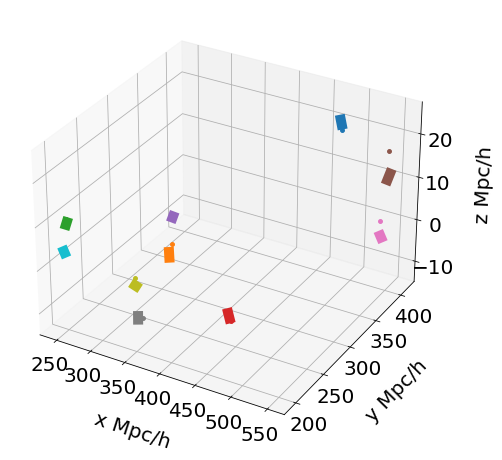

In [61]:
#- Plot segments and galaxies examples
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')
for N in np.arange(10):
    ax.scatter3D(np.array(df_pos_des['ROTCARTESIAN_X'])[N],
                 np.array(df_pos_des['ROTCARTESIAN_Y'])[N],
                 np.array(df_pos_des['ROTCARTESIAN_Z'])[N], s=15)
    
    ax.plot3D(fila_x_arr[ID_FILA_SEGMENTS[N]],
              fila_y_arr[ID_FILA_SEGMENTS[N]],
              fila_z_arr[ID_FILA_SEGMENTS[N]], lw=10)
    
#     ax.plot3D([np.array(df_pos['ROTCARTESIAN_X'])[N], fila_x_arr[ID_FILA_SEGMENTS[N]][0]],
#               [np.array(df_pos['ROTCARTESIAN_Y'])[N], fila_y_arr[ID_FILA_SEGMENTS[N]][0]],
#               [np.array(df_pos['ROTCARTESIAN_Z'])[N], fila_z_arr[ID_FILA_SEGMENTS[N]][0]], '--', lw=1)
    
#     ax.plot3D([np.array(df_pos['ROTCARTESIAN_X'])[N], fila_x_arr[ID_FILA_SEGMENTS[N]][1]],
#               [np.array(df_pos['ROTCARTESIAN_Y'])[N], fila_y_arr[ID_FILA_SEGMENTS[N]][1]],
#               [np.array(df_pos['ROTCARTESIAN_Z'])[N], fila_z_arr[ID_FILA_SEGMENTS[N]][1]], '--', lw=1)


In [62]:
# df_filaments = pd.DataFrame()
# df_filaments['FILAMENTS'] = FILA    #Save the filaments
# df_filaments['LEN_FILA'] = LEN_FILA # Save the number of point of each filament
# df_filaments['ID_FILA_SEGMENT'] = ID_FILA_SEGMENTS # Save the ids of the nearest filament segments by galaxy

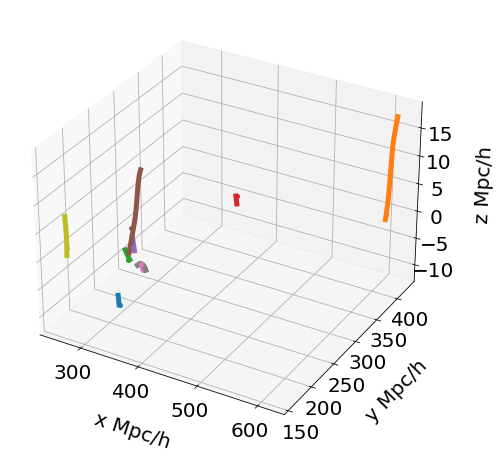

In [63]:
#- Plot Filaments that have more than 0 galxies near and within a min_dis_fil in 3D
Ns = np.arange(100)
fig = pl.figure(figsize=(8,8))
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_zlabel('z Mpc/h')

min_dis_fil = 3

for N in Ns:
    ii_fila = ID_FILA == N
    ii_fila_distance = distances_fila[ii_fila] < min_dis_fil
    if  sum(ii_fila_distance)>0:
        ax.scatter3D(data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_X'][ii_fila][ii_fila_distance],
                     data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_Y'][ii_fila][ii_fila_distance],
                     data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_Z'][ii_fila][ii_fila_distance], s=15)
        ax.plot3D(FILA[N][:,0], FILA[N][:,1], FILA[N][:,2], lw=5)

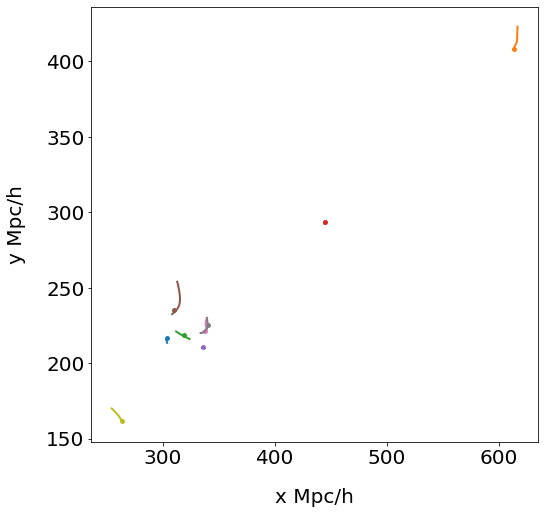

In [64]:
#- Same figure in 2D
Ns = np.arange(100)
fig = pl.figure(figsize=(8,8))

for N in Ns:
    ii_fila = ID_FILA == N
    ii_fila_distance = distances_fila[ii_fila] < min_dis_fil
    if sum(ii_fila_distance) != 0:
        pl.scatter(data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_X'][ii_fila][ii_fila_distance],
                     data_match[ii_ddp1 & ii_g15 & ii_distance]['ROTCARTESIAN_Y'][ii_fila][ii_fila_distance], s=15)
        pl.plot(FILA[N][:,0], FILA[N][:,1], lw=2)
pl.xlabel('x Mpc/h')
pl.ylabel('y Mpc/h')
pl.show()

In [65]:
len(ID_FILA)

293

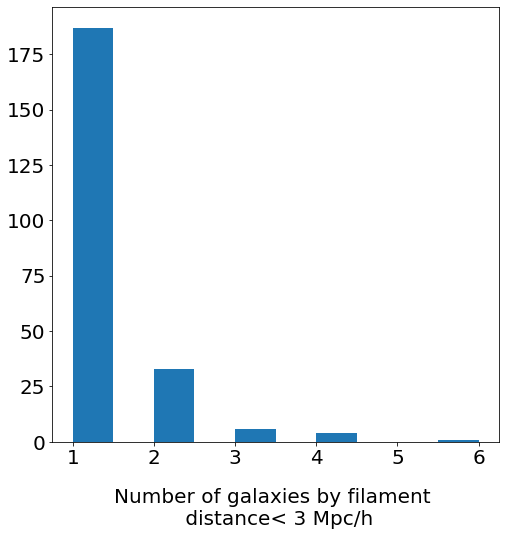

In [66]:
fig = pl.figure(figsize=(8,8))
_, counts = np.unique(ID_FILA, return_counts=True)
pl.hist(counts)
pl.xlabel(f'Number of galaxies by filament \n distance< {min_dis_fil} Mpc/h') # Number of points by filament with a minimal distance of min_dist to filament
pl.show()

## Computing the Tilt of the Segments

In [67]:
from astropy.coordinates import SkyCoord

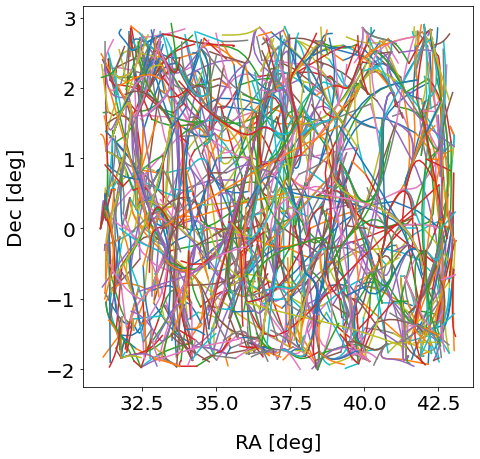

In [68]:
#- Projection of the filaments in the RADEC space
Ns = np.arange(1)
fig = pl.figure(figsize=(7,7))

for fil in FILA:
    # print(sum(ii_fila_distance))    
    c = SkyCoord(x=fil[:,0], y=fil[:,1], z=fil[:,2], unit='Mpc/h', representation_type='cartesian')
    c.representation_type = 'spherical'
    pl.plot(c.to_table()['ra'], c.to_table()['dec'])
    
pl.xlabel('RA [deg]')
pl.ylabel('Dec [deg]')
pl.show()

In [69]:
c = SkyCoord(x=fil[:,0]*-1, y=fil[:,1]*-1, z=fil[:,2], unit='Mpc/h', representation_type='cartesian')
c.representation_type = 'unitspherical'
c.to_table()

ra,dec
deg,deg
float64,float64
212.54678941318446,-1.6124814927332136
212.68411017491408,-1.5220210488063801
212.8212639805219,-1.4316542874017726


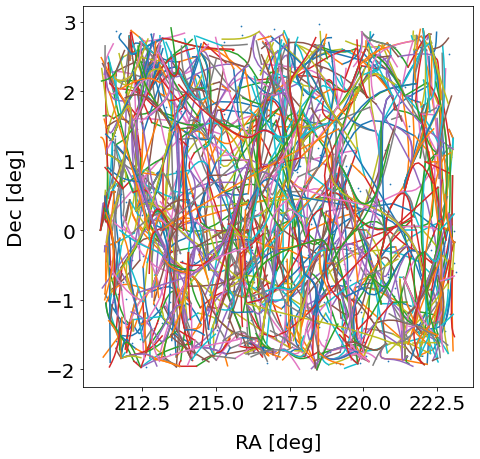

In [70]:
#- Filaments and galaxies projected in RADEC
fig = pl.figure(figsize=(7,7))

for fil in FILA:
    # print(sum(ii_fila_distance))    
    c = SkyCoord(x=fil[:,0]*-1, y=fil[:,1]*-1, z=fil[:,2], unit='Mpc/h', representation_type='cartesian')
    c.representation_type = 'spherical'
    pl.plot(np.array(c.to_table()['ra']), np.array(c.to_table()['dec'])) #- Review?
    
pl.scatter(data_match[ii_ddp1 & ii_g15 & ii_distance]['RA'],
           data_match[ii_ddp1 & ii_g15 & ii_distance]['DEC'], s=0.5)
pl.xlabel('RA [deg]')
pl.ylabel('Dec [deg]')
pl.show()

In [71]:
# len(ID_FILA_SEGMENTS)

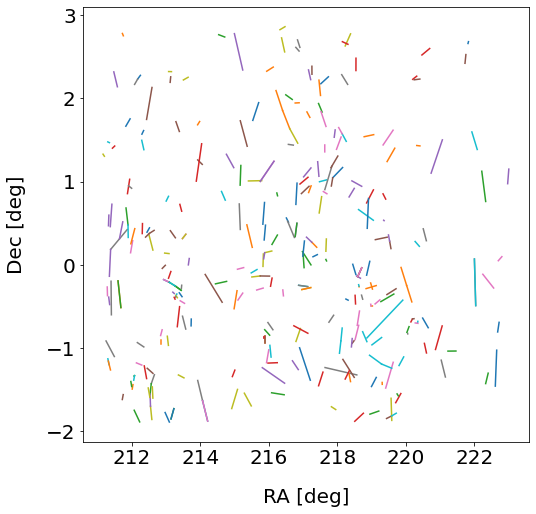

In [72]:
#- Filaments and galaxies projected in RADEC with a correction in RA +180.5
fig = pl.figure(figsize=(8,8))

c = SkyCoord(x=fila_x_arr*-1, y=fila_y_arr*-1, z=fila_z_arr, unit='Mpc/h', representation_type='cartesian')
c.representation_type = 'spherical'

ra_fila_segment   = []
dec_fila_segment  = []
tilt_fila_segment = []

for i, ifs in enumerate(ID_FILA_SEGMENTS):
    ra_ = [c.to_table()[ 'ra'][ifs[0]].to_value(), c.to_table()[ 'ra'][ifs[1]].to_value()]
    dec_ = [c.to_table()['dec'][ifs[0]].to_value(), c.to_table()['dec'][ifs[1]].to_value()]
    ra_fila_segment.append(ra_)
    dec_fila_segment.append(dec_)
    
    tilt_temp = np.arctan2( dec_[1]-dec_[0], ra_[1]-ra_[0] )*180/np.pi
    
    if tilt_temp < 0:
        tilt_temp = tilt_temp + 180
    
    # print(tilt_temp)
    tilt_fila_segment.append(tilt_temp)
    
    pl.plot(ra_,dec_)
    
    # pl.axis('equal')
    
# pl.scatter(data_match[ii_ddp1 & ii_g15 & ii_distance]['RA'],
#            data_match[ii_ddp1 & ii_g15 & ii_distance]['DEC'], s=5)
pl.xlabel('RA [deg]')
pl.ylabel('Dec [deg]')
pl.show()

In [73]:
#- DataFrame with PHI, RA, DEC galaxie and X,Y,Z,RAs,Decs and TILT segments
c = SkyCoord(x=fila_x_arr, y=fila_y_arr, z=fila_z_arr, unit='Mpc/h', representation_type='cartesian')
c.representation_type = 'spherical'

[c.to_table()[ 'ra'][ifs[0]].to_value(), c.to_table()[ 'ra'][ifs[1]].to_value()],
[c.to_table()['dec'][ifs[0]].to_value(), c.to_table()['dec'][ifs[1]].to_value()]

df_segments = pd.DataFrame()
x_fila_segment = [ fila_x_arr[ids] for ids in ID_FILA_SEGMENTS]
y_fila_segment = [ fila_y_arr[ids] for ids in ID_FILA_SEGMENTS]
z_fila_segment = [ fila_z_arr[ids] for ids in ID_FILA_SEGMENTS]

df_segments['PHI_DES'] = data_match['PHI_DES'][ii_ddp1 & ii_distance & ii_g15]*180/np.pi + 90 # Between 0 to 180 in deg
df_segments['RA_DES'] = data_match['RA_DES'][ii_ddp1 & ii_distance & ii_g15]
df_segments['DEC_DES'] = data_match['DEC_DES'][ii_ddp1 & ii_distance & ii_g15]
df_segments['X_NEAREST_SEGMENT']   = x_fila_segment
df_segments['Y_NEAREST_SEGMENT']   = y_fila_segment
df_segments['Z_NEAREST_SEGMENT']   = z_fila_segment
df_segments['RA_NEAREST_SEGMENT']  = ra_fila_segment
df_segments['DEC_NEAREST_SEGMENT'] = dec_fila_segment
df_segments['TILT_NEAREST_SEGMENT'] = tilt_fila_segment

df_segments

,PHI_DES,RA_DES,DEC_DES,X_NEAREST_SEGMENT,Y_NEAREST_SEGMENT,Z_NEAREST_SEGMENT,RA_NEAREST_SEGMENT,DEC_NEAREST_SEGMENT,TILT_NEAREST_SEGMENT
0,49.626919,217.879142,2.113523,"[495.631, 493.28]","[380.532, 381.753]","[23.7264, 24.5922]","[217.5160735925606, 217.73654996208467]","[2.1745058070989387, 2.2578056692220434]",20.697450
1,11.889977,220.370832,0.027249,"[330.937, 330.388]","[277.915, 278.94]","[-1.87238, -3.35647]","[220.02294179290928, 220.1737354377917]","[-0.24824275025996667, -0.44475206111417126]",127.501238
2,80.562011,217.762677,2.134375,"[256.332, 255.188]","[196.331, 196.188]","[10.9197, 10.3119]","[217.4493942810566, 217.55300731810473]","[1.936982686203212, 1.8348925077157365]",135.424163
3,52.115820,212.565708,-1.335539,"[425.0, 424.127]","[270.0, 268.741]","[-12.0, -10.6362]","[212.42755499577245, 212.35970930698915]","[-1.3652471475607673, -1.213537141279447]",114.094500
4,120.496955,219.199508,1.044057,"[340.899, 342.711]","[273.205, 271.863]","[7.19235, 7.69863]","[218.70956003873314, 218.42397902849063]","[0.9432017608252907, 1.0082432063911229]",167.169663
...,...,...,...,...,...,...,...,...,...
288,34.008551,213.507929,0.153829,"[615.019, 612.748]","[398.715, 399.175]","[1.80748, 1.7273]","[212.9552221411907, 213.08225300085007]","[0.14129225262089373, 0.13532984265944825]",177.312697
289,10.751794,218.919176,-1.216524,"[349.0, 345.967]","[282.0, 283.073]","[-8.5, -9.29217]","[218.939005805132, 219.2903086904263]","[-1.085277402311387, -1.190841522054171]",163.274836
290,73.771566,216.093778,0.739328,"[461.067, 462.847]","[333.285, 335.048]","[2.96752, 4.75459]","[215.86150670744757, 215.90021512431312]","[0.29885925754288023, 0.47675405174610475]",77.724267
291,5.039933,220.289867,0.091908,"[331.479, 330.937]","[276.752, 277.915]","[-0.234515, -1.87238]","[219.85852403465216, 220.02294179290928]","[-0.0311163561772862, -0.24824275025996667]",127.134624


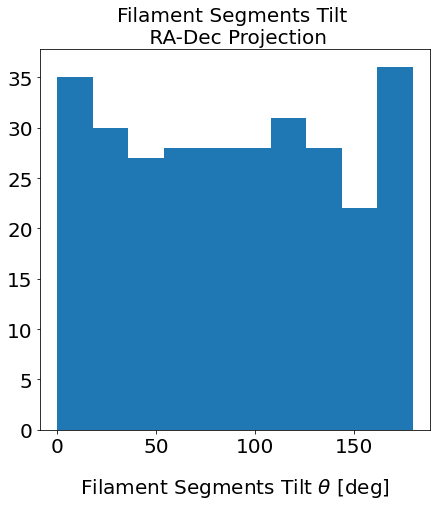

In [74]:
#- Histogram of the Tilt segments
fig = pl.figure(figsize=(7,7))
_ = pl.hist(np.array(tilt_fila_segment))
len(tilt_fila_segment)
pl.title('Filament Segments Tilt \n RA-Dec Projection')
pl.xlabel(r'Filament Segments Tilt $\theta$ [deg]')
pl.show()

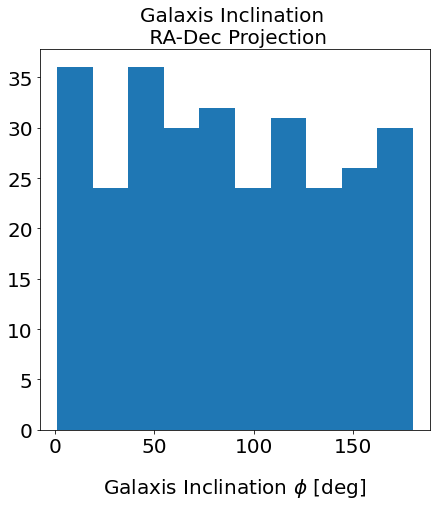

In [75]:
#- Histogram of the Galaxy inclinations
fig = pl.figure(figsize=(7,7))
_ = pl.hist(df_segments['PHI_DES'])
pl.title('Galaxis Inclination \n RA-Dec Projection')
pl.xlabel(r'Galaxis Inclination $\phi$ [deg]')
pl.show()

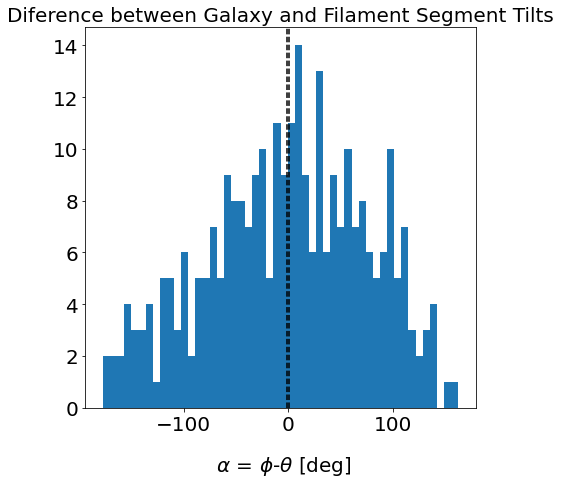

In [76]:
#- Hist of the Diference between Galaxy and Filament Segment Tilts
fig = pl.figure(figsize=(7,7))
diff = df_segments['PHI_DES'] - df_segments['TILT_NEAREST_SEGMENT']
_ = pl.hist(diff, bins=50)
pl.xlabel(r' $\alpha$ = $\phi$-$\theta$ [deg]')
lim = 1
pl.axvline(lim, ls='--', c='black')
pl.axvline(-lim, ls='--', c='black')
pl.title('Diference between Galaxy and Filament Segment Tilts')
pl.show()

1 Galaxies with alignment less than 2 deg


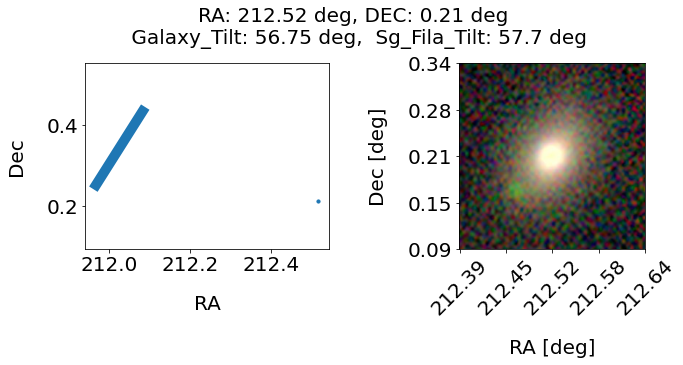

In [77]:
#- Plot some examples of Galaxies and Filamentary segments For a difference less than #degrees
ii_diff = (diff < lim) & (diff > -lim) 
ii_aligned = np.where(ii_diff == True)[0]
print(f'{len(ii_aligned)} Galaxies with alignment less than {2*lim} deg')

for ii_al in ii_aligned[:5]:
    fig = pl.figure(figsize=(10,5))
    
    ra__ = np.array(df_segments['RA_DES'])[ii_al]
    dec__ = np.array(df_segments['DEC_DES'])[ii_al]    
    
    pl.subplot(1,2,1)
    pl.plot(np.array(df_segments['RA_NEAREST_SEGMENT'])[ii_al], np.array(df_segments['DEC_NEAREST_SEGMENT'])[ii_al], lw=10)
    pl.scatter(ra__, dec__, s=10)
    pl.xlabel('RA')
    pl.ylabel('Dec')
    pl.axis('equal')

    url_DES = f'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra__}&dec={dec__}&layer=ls-dr9&zoom=16'
    IMAGE_DES = load_image(url_DES)
    
    pl.subplot(1,2,2)
    pl.imshow(IMAGE_DES)    
    pl.xticks(np.linspace(0,len(IMAGE_DES[:,0]),5), np.around(np.linspace(ra__-0.125, ra__+0.125, 5), decimals=2), rotation = 45)
    pl.yticks(np.linspace(0,len(IMAGE_DES[:,0]),5), np.around(np.sort(np.linspace(dec__-0.125, dec__+0.125, 5))[::-1], decimals=2))
    pl.xlabel('RA [deg]')
    pl.ylabel('Dec [deg]')
    
    tilt_galaxy = df_segments['PHI_DES'][ii_al]
    tilt_fila = df_segments['TILT_NEAREST_SEGMENT'][ii_al]
    
    pl.suptitle(f'RA: {round(ra__,2)} deg, DEC: {round(dec__,2)} deg \n Galaxy_Tilt: {round(tilt_galaxy,2)} deg,  Sg_Fila_Tilt: {round(tilt_fila,2)} deg')
    pl.tight_layout()
    pl.show()